# Notebook to process Trios data from the mission on the Thau lagoon (fall 2022)

In [27]:
import os
import numpy as np, pandas as pd, xarray as xr

import glob
import re
import datetime

from scipy.interpolate import interp1d
import suncalc

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rc = {"font.family": "serif", "mathtext.fontset": "stix", 'font.size': 14, 'axes.labelsize': 16}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


from trios import __version__
from trios import awr_process, iwr_process, swr_process, utils
opj = os.path.join
__version__

'1.0.1'

### Get and reshape the data

In [2]:
datadir = '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios'
idpr = os.listdir(datadir)
idpr=pd.DataFrame(idpr, columns=['rep'])
idpr['ID']=idpr['rep'].str.replace('TH_PR','').astype(int)
idpr = idpr.set_index('ID').sort_index()

lon, lat = 3.6, 43.4
elevation=0

### Start with one given sample

In [3]:
id = 7
rep =idpr.loc[id].rep
files= glob.glob(opj(datadir,rep,'*'))
files

['/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _Lt.xlsx',
 '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _Rrs.xlsx',
 '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _Ls.xlsx',
 '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _ed.xlsx']

#### Implement a reader for your format to get xarray with dates and wavelength dimenions

In [4]:
def reshape_data(file,common_wl=None,name=''):
    data = pd.read_excel(file,index_col=0).dropna()
    data = data.drop(['mean','stdv'],axis=1).T
    data.index=pd.to_datetime(data.index)
    data = data.stack()
    data.index.names=['date','wl']
    data = data.to_xarray()
    data.name=name
    if common_wl is not None:
        data = data.interp(wl=common_wl)
    return data

In [5]:
# set common wavelengths to reproject on:319, 322, 326, 329, 332, 336, 339, 342, 346, 
common_wl = np.array([350, 352, 356, 359, 362,
       366, 369, 372, 376, 379, 382, 386, 389, 392, 396, 399, 402, 406, 409,
       412, 416, 419, 422, 426, 429, 432, 436, 439, 442, 446, 449, 452, 456,
       459, 462, 466, 469, 472, 476, 479, 482, 486, 489, 492, 496, 499, 502,
       506, 509, 513, 516, 519, 523, 526, 529, 533, 536, 539, 543, 546, 549,
       553, 556, 559, 563, 566, 569, 573, 576, 579, 583, 586, 589, 593, 596,
       599, 603, 606, 609, 613, 616, 620, 623, 626, 630, 633, 636, 640, 643,
       646, 650, 653, 656, 660, 663, 666, 670, 673, 676, 680, 683, 686, 690,
       693, 696, 700, 703, 706, 710, 713, 716, 720, 723, 726, 730, 733, 736,
       739, 743, 746, 749, 753, 756, 759, 763, 766, 769, 773, 776, 779, 783,
       786, 789, 793, 796, 799, 802, 806, 809, 812, 816, 819, 822, 826, 829,
       832, 836, 839, 842, 845, 849, 852, 855, 859, 862, 865, 868, 872, 875,
       878, 882, 885, 888, 891, 895, 898, 901, 905, 908, 911, 914, 918, 921,
       924, 927, 931, 934, 937, 940, 944, 947, 950])
# set file paths
Edfile = opj(datadir,rep,rep+' _ed.xlsx')
Lsfile = opj(datadir,rep,rep+' _Ls.xlsx')
Ltfile = opj(datadir,rep,rep+' _Lt.xlsx')
# open and merge
data = xr.merge([reshape_data(Edfile,name='Ed',common_wl=common_wl),
          reshape_data(Lsfile,name='Ls',common_wl=common_wl),
          reshape_data(Ltfile,name= 'Lt',common_wl=common_wl)])
data

<xarray.Dataset>
Dimensions:  (date: 29, wl: 182)
Coordinates:
  * date     (date) datetime64[ns] 2022-11-30T11:34:43 ... 2022-11-30T11:39:23
  * wl       (wl) int64 350 352 356 359 362 366 369 ... 934 937 940 944 947 950
Data variables:
    Ed       (date, wl) float64 173.9 180.3 182.7 187.1 ... 99.18 100.5 104.1
    Ls       (date, wl) float64 24.79 25.54 25.72 25.65 ... 0.5789 0.6258 nan
    Lt       (date, wl) float64 0.7569 0.774 0.7681 ... 0.01787 0.0185 0.01637

#### Get Sun zenith angles, you need to know lon, lat and UTC time:


In [6]:
sun = suncalc.get_position(data.date,lon, lat)
sza=90-np.degrees(sun['altitude'])
data['sza'] = ('date',sza.values)

In [7]:
data.sza

<xarray.DataArray 'sza' (date: 29)>
array([65.01836691, 65.01841508, 65.01848583, 65.01857914, 65.01869502,
       65.01883347, 65.01899448, 65.01917807, 65.01938422, 65.01961294,
       65.01986422, 65.02013807, 65.02043449, 65.02075348, 65.02109503,
       65.02145914, 65.02184582, 65.02225507, 65.02268688, 65.02314125,
       65.02361818, 65.02411768, 65.02463974, 65.02518437, 65.02575155,
       65.02634129, 65.0269536 , 65.02758846, 65.02824588])
Coordinates:
  * date     (date) datetime64[ns] 2022-11-30T11:34:43 ... 2022-11-30T11:39:23

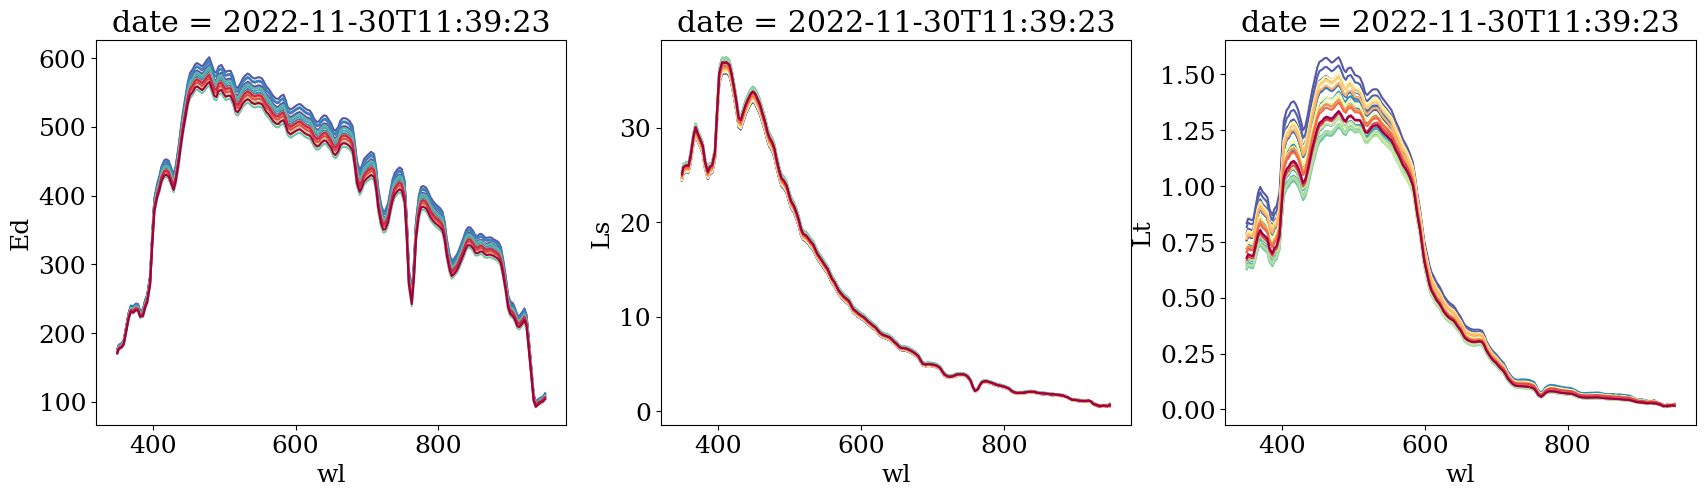

In [8]:
import matplotlib as mpl
cmap = plt.cm.Spectral_r
norm = mpl.colors.Normalize(vmin=np.min(data.sza),vmax=np.max(data.sza))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)
#axs.minorticks_on()
for sza,data_ in data.groupby('sza'):
    data_.Ed.plot(c=cmap(norm(sza)),ax=axs[0],add_legend=False)
    data_.Ls.plot(c=cmap(norm(sza)),ax=axs[1],add_legend=False)
    data_.Lt.plot(c=cmap(norm(sza)),ax=axs[2],add_legend=False)
plt.show()

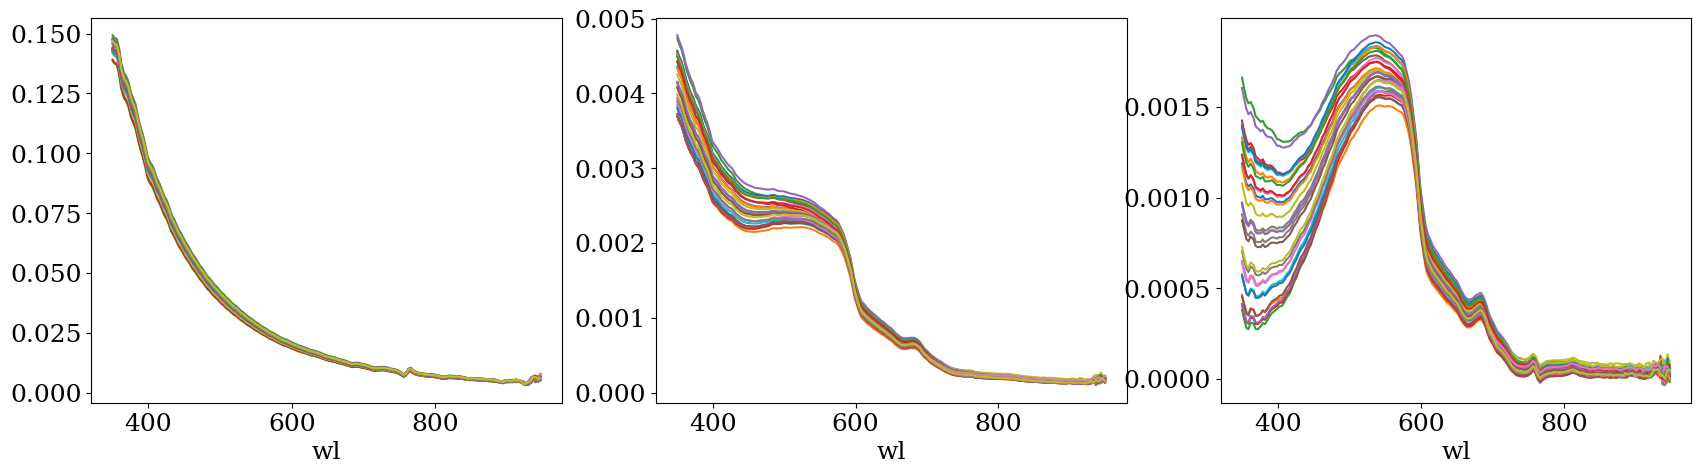

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)
(data.Ls/data.Ed).plot(hue='date',ax=axs[0],add_legend=False)
(data.Lt/data.Ed).plot(hue='date',ax=axs[1],add_legend=False)
((data.Lt-0.0222*data.Ls)/data.Ed).plot(hue='date',ax=axs[2],add_legend=False)

plt.show()

In [10]:
awr_fine = awr_process(wl=common_wl[common_wl>=350], aerosol = 'fine')
rho = awr_fine.get_rho_values #(60,40,135,wl=common_wl)
#rho_mobley = awr_fine.get_rho_mobley
rho_mobley  = awr_fine.rhoM1999.to_xarray().rho

In [11]:
# import osooa_opac model
rho_factor = xr.open_dataset('/data/vrtc/xlut/rho_factor_osoaa_opac.nc').isel(aot_ref=1,vza=27,model=0).sel(azi=[45,90]).I
rho_factor['wl'] = rho_factor.wl*1000

In [21]:
sza = data.sza.mean()

rho_factor_ =rho_factor.interp(sza=sza).interp(wl=common_wl)
rho_factor_.isel(wl=0)

<xarray.DataArray 'I' (wind: 6, azi: 2)>
array([[0.02347755, 0.01525005],
       [0.02393788, 0.0157734 ],
       [0.02456468, 0.01651324],
       [0.02568631, 0.01800292],
       [0.02646305, 0.01930614],
       [0.0269139 , 0.02036191]])
Coordinates:
    aot_ref  float32 0.01
  * wind     (wind) float64 0.5 2.0 4.0 8.0 12.0 16.0
    vza      float32 39.96
  * azi      (azi) float32 45.0 90.0
    model    <U9 'COAV_rh70'
    sza      float64 81.39
    wl       int64 350

In [13]:
data.Lt

<xarray.DataArray 'Lt' (date: 29, wl: 182)>
array([[0.75685105, 0.77401356, 0.76811388, ..., 0.02141441, 0.0198532 ,
        0.02254447],
       [0.75735718, 0.77532891, 0.7690787 , ..., 0.01798348, 0.02174452,
        0.02066009],
       [0.83450743, 0.8544686 , 0.84885686, ..., 0.02044795, 0.01883087,
        0.0234059 ],
       ...,
       [0.66860454, 0.68358738, 0.67742297, ..., 0.01920242, 0.02036662,
        0.02366803],
       [0.67756026, 0.69254974, 0.68703343, ..., 0.01666546, 0.01906315,
        0.01599591],
       [0.67975841, 0.69502999, 0.6892254 , ..., 0.01787354, 0.01850087,
        0.01637279]])
Coordinates:
  * date     (date) datetime64[ns] 2022-11-30T11:34:43 ... 2022-11-30T11:39:23
  * wl       (wl) int64 350 352 356 359 362 366 369 ... 934 937 940 944 947 950

In [14]:
azi=135
vza=40

rho_M = rho_mobley.sel(wind=2).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')
Rrs=(data.Lt-rho(sza,vza,azi,wl=common_wl)*data.Ls)/data.Ed
Rrs_opac=(data.Lt-rho_factor_.sel(azi=45)*data.Ls)/data.Ed
Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
rho_factor

<xarray.DataArray 'I' (wind: 6, wl: 10, sza: 45, azi: 2)>
[5400 values with dtype=float32]
Coordinates:
  * wl       (wl) float32 350.0 400.0 500.0 600.0 ... 1.6e+03 2.2e+03 2.5e+03
    aot_ref  float32 0.01
  * sza      (sza) float32 0.0 2.0 4.0 6.0 8.0 10.0 ... 80.0 82.0 84.0 86.0 88.0
  * wind     (wind) float64 0.5 2.0 4.0 8.0 12.0 16.0
    vza      float32 39.96
  * azi      (azi) float32 45.0 90.0
    model    <U9 'COAV_rh70'

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


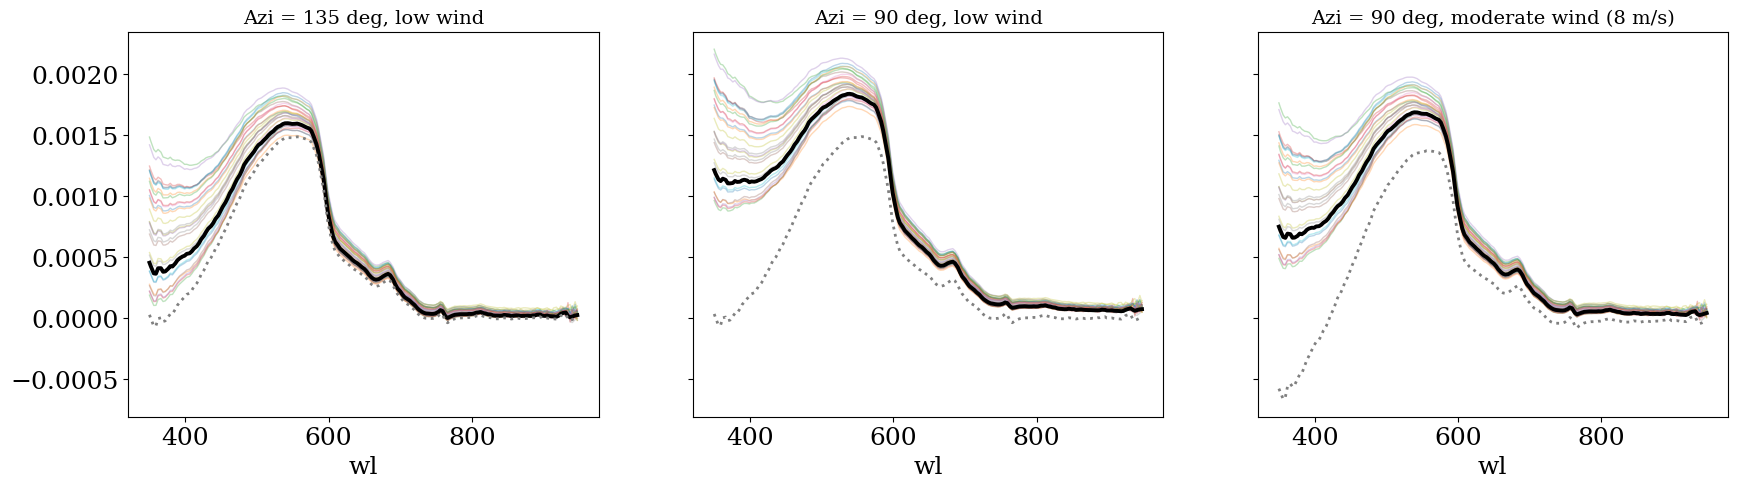

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5),sharey=True)
fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)


azi=135
vza=40
title='Azi = 135 deg, low wind'
rho_M = rho_mobley.sel(wind=2).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')
#Rrs=(data.Lt-rho(sza,vza,azi,wl=common_wl)*data.Ls)/data.Ed
Rrs_opac=(data.Lt-rho_factor_.isel(wind=0).sel(azi=180-azi)*data.Ls)/data.Ed
Rrs_opac.plot(hue='date',add_legend=False,lw=1,ax=axs[0],alpha=0.3)
Rrs_opac.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[0])
#Rrs_opac=(data.Lt-rho_factor_.sel(azi=90)*data.Ls)/data.Ed
#Rrs_opac.quantile(0.25,dim='date').plot(c='r',lw=2.8,ax=axs[0])

Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[0],label='rho_M99')
axs[0].set_title(title,fontsize=14)

azi=90
vza=40
title='Azi = 90 deg, low wind'
Rrs_opac=(data.Lt-rho_factor_.isel(wind=0).sel(azi=180-azi)*data.Ls)/data.Ed
Rrs_opac.plot(hue='date',add_legend=False,lw=1,ax=axs[1],alpha=0.3)
Rrs_opac.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[1])


#Rrs=(data.Lt-rho(sza,vza,azi,wl=common_wl)*data.Ls)/data.Ed

#Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[1],alpha=0.3,label=None)
#Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[1])
rho_M = rho_mobley.sel(wind=2).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')

Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[1],label='rho_M99')
axs[1].set_title(title,fontsize=14)

wind=8
title='Azi = 90 deg, moderate wind (8 m/s)'
rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')
#Rrs=(data.Lt-rho(sza,vza,azi,ws=[wind],wl=common_wl)*data.Ls)/data.Ed
Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
Rrs_opac=(data.Lt-rho_factor_.isel(wind=3).sel(azi=180-azi)*data.Ls)/data.Ed
Rrs_opac.plot(hue='date',add_legend=False,lw=1,ax=axs[2],alpha=0.3)
Rrs_opac.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[2])
#Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[2],alpha=0.3)
#Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.,ax=axs[2],label='rho_h')
Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[2],label='rho_M99')
axs[2].set_title(title,fontsize=14)

plt.show()

## Putting all together, process all the stations and save results into netcdf file

In [22]:
common_wl

array([350, 352, 356, 359, 362, 366, 369, 372, 376, 379, 382, 386, 389,
       392, 396, 399, 402, 406, 409, 412, 416, 419, 422, 426, 429, 432,
       436, 439, 442, 446, 449, 452, 456, 459, 462, 466, 469, 472, 476,
       479, 482, 486, 489, 492, 496, 499, 502, 506, 509, 513, 516, 519,
       523, 526, 529, 533, 536, 539, 543, 546, 549, 553, 556, 559, 563,
       566, 569, 573, 576, 579, 583, 586, 589, 593, 596, 599, 603, 606,
       609, 613, 616, 620, 623, 626, 630, 633, 636, 640, 643, 646, 650,
       653, 656, 660, 663, 666, 670, 673, 676, 680, 683, 686, 690, 693,
       696, 700, 703, 706, 710, 713, 716, 720, 723, 726, 730, 733, 736,
       739, 743, 746, 749, 753, 756, 759, 763, 766, 769, 773, 776, 779,
       783, 786, 789, 793, 796, 799, 802, 806, 809, 812, 816, 819, 822,
       826, 829, 832, 836, 839, 842, 845, 849, 852, 855, 859, 862, 865,
       868, 872, 875, 878, 882, 885, 888, 891, 895, 898, 901, 905, 908,
       911, 914, 918, 921, 924, 927, 931, 934, 937, 940, 944, 94

TH_PR2


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR3


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR4


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR5


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR6


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR7


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR8


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR9


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR10


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


TH_PR11


/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


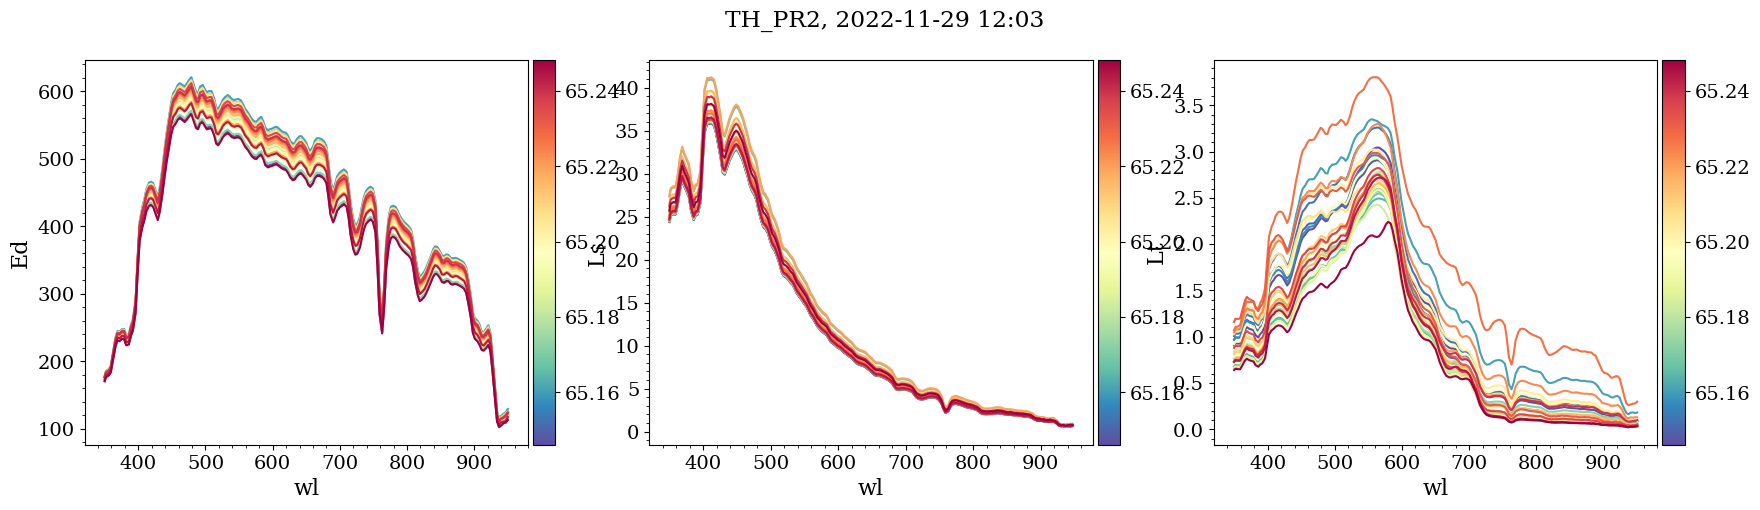

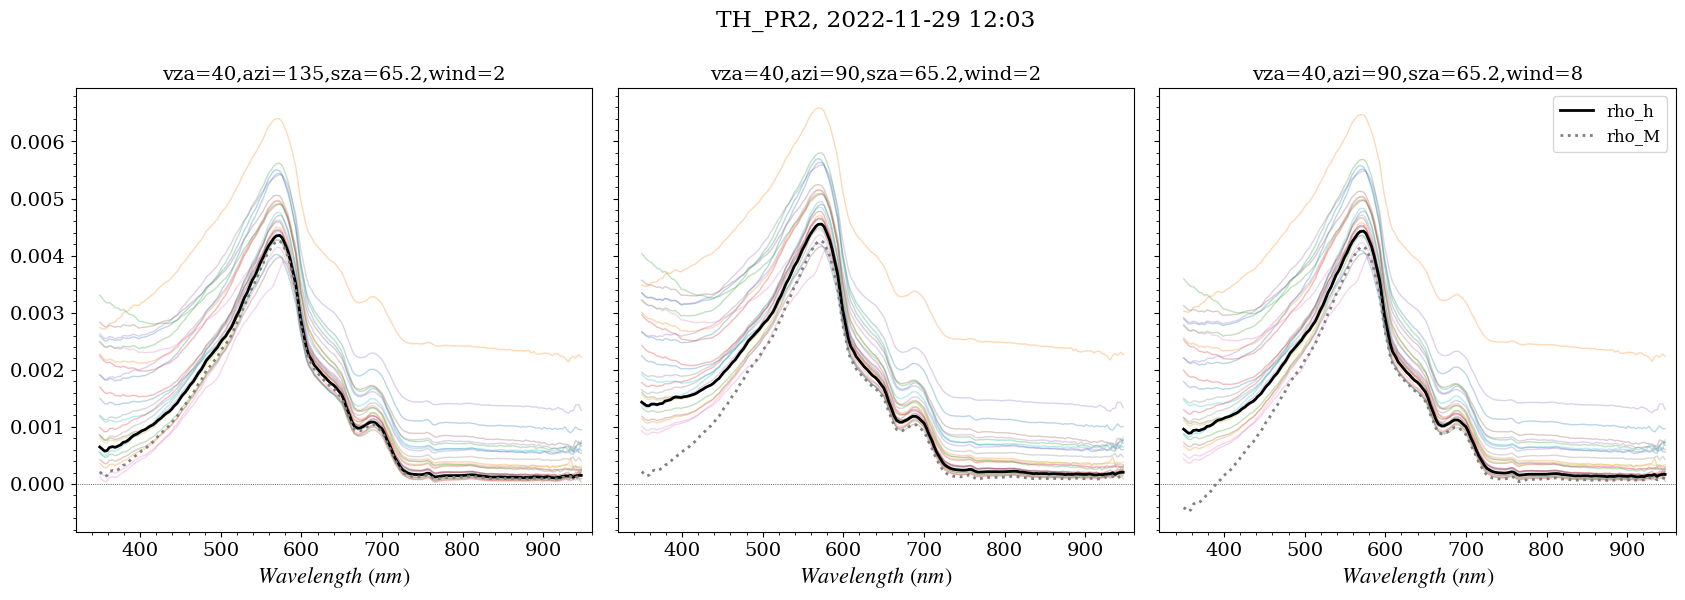

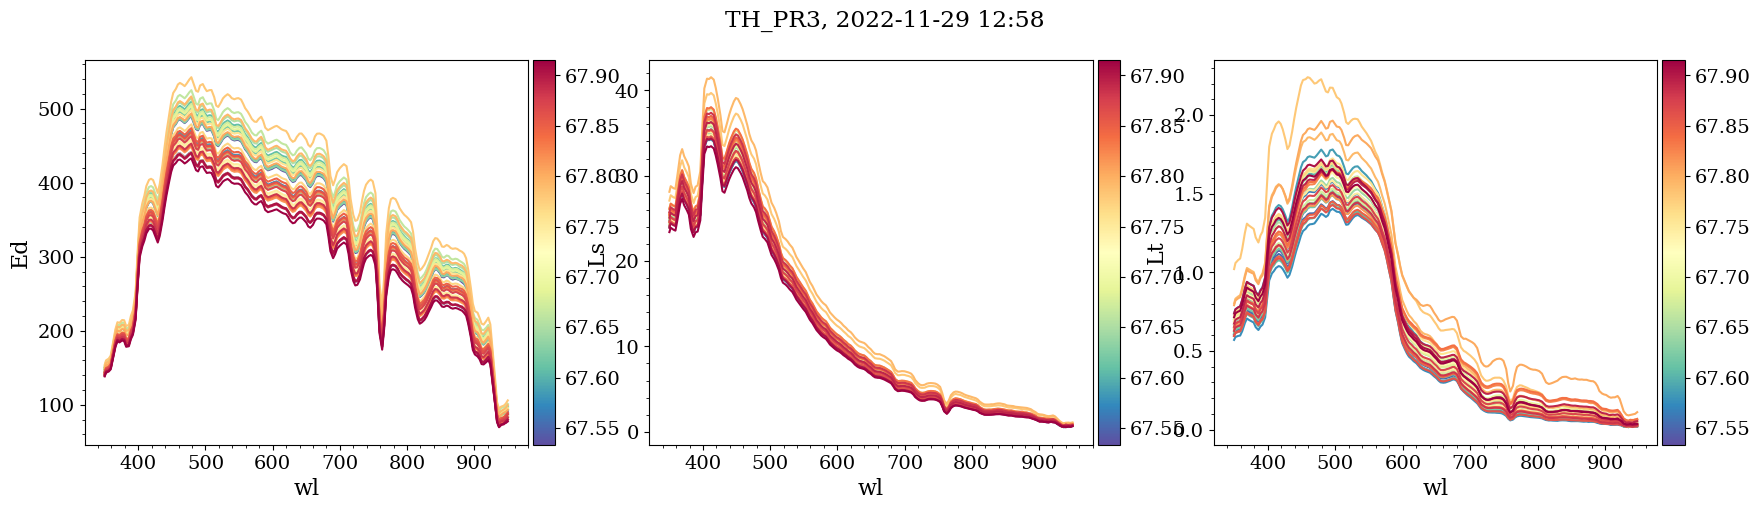

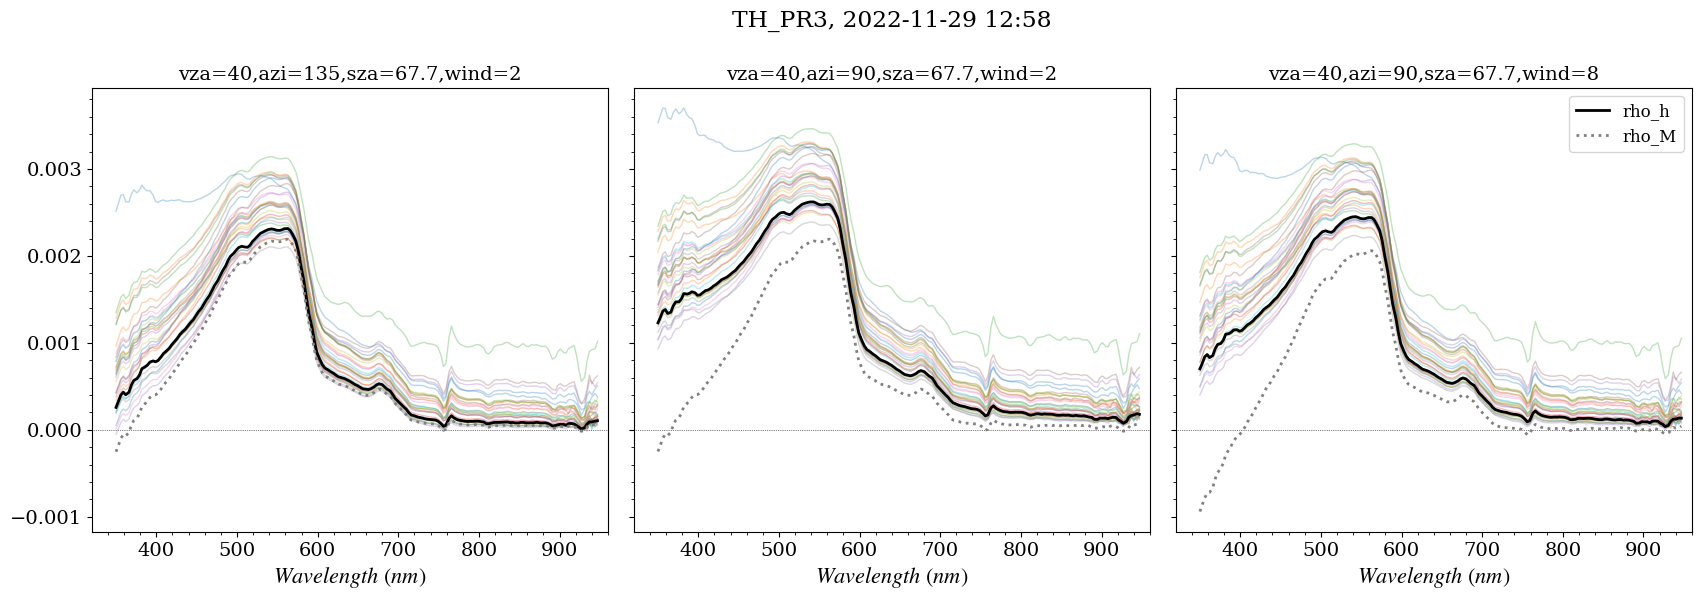

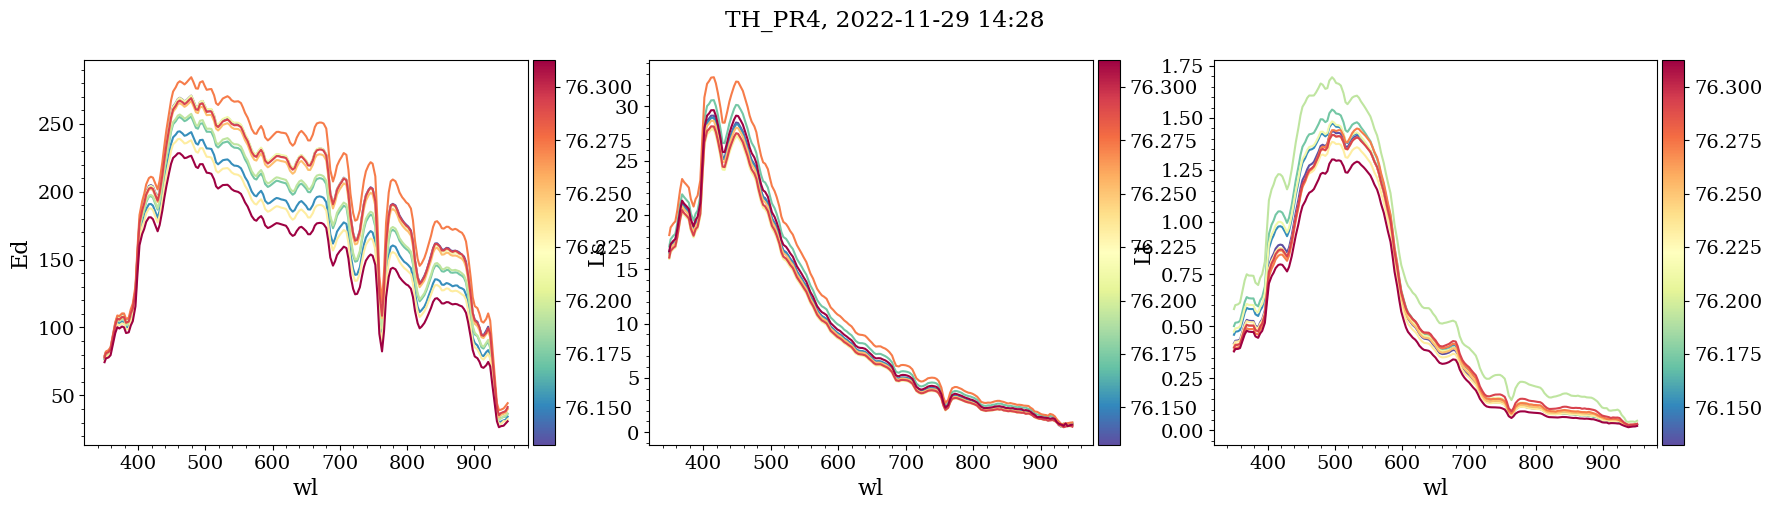

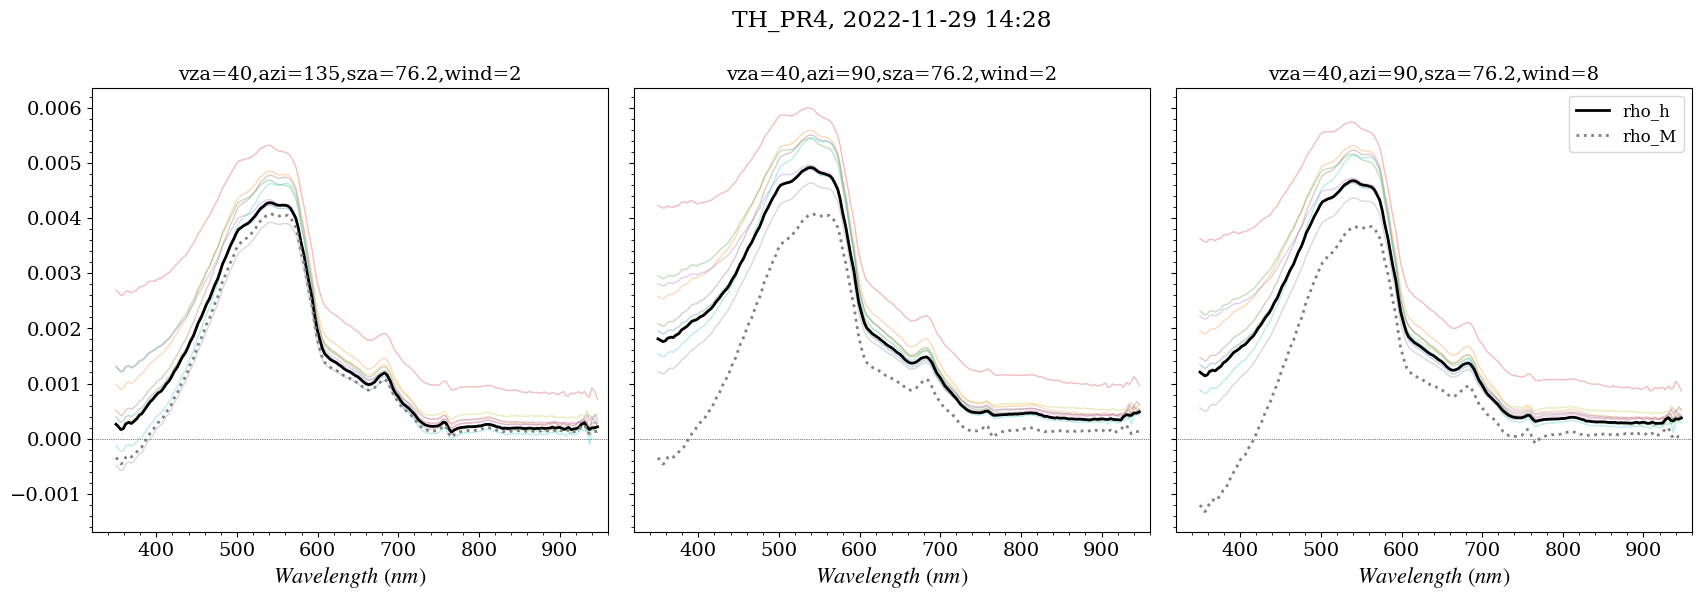

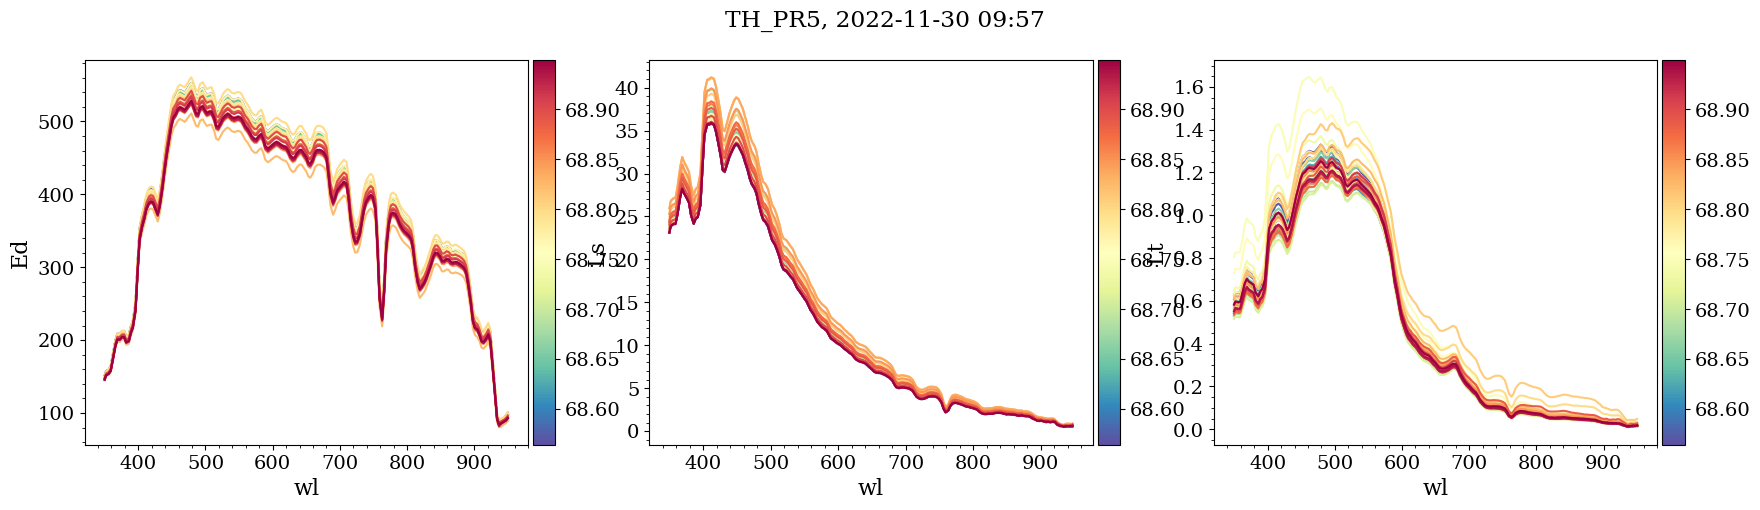

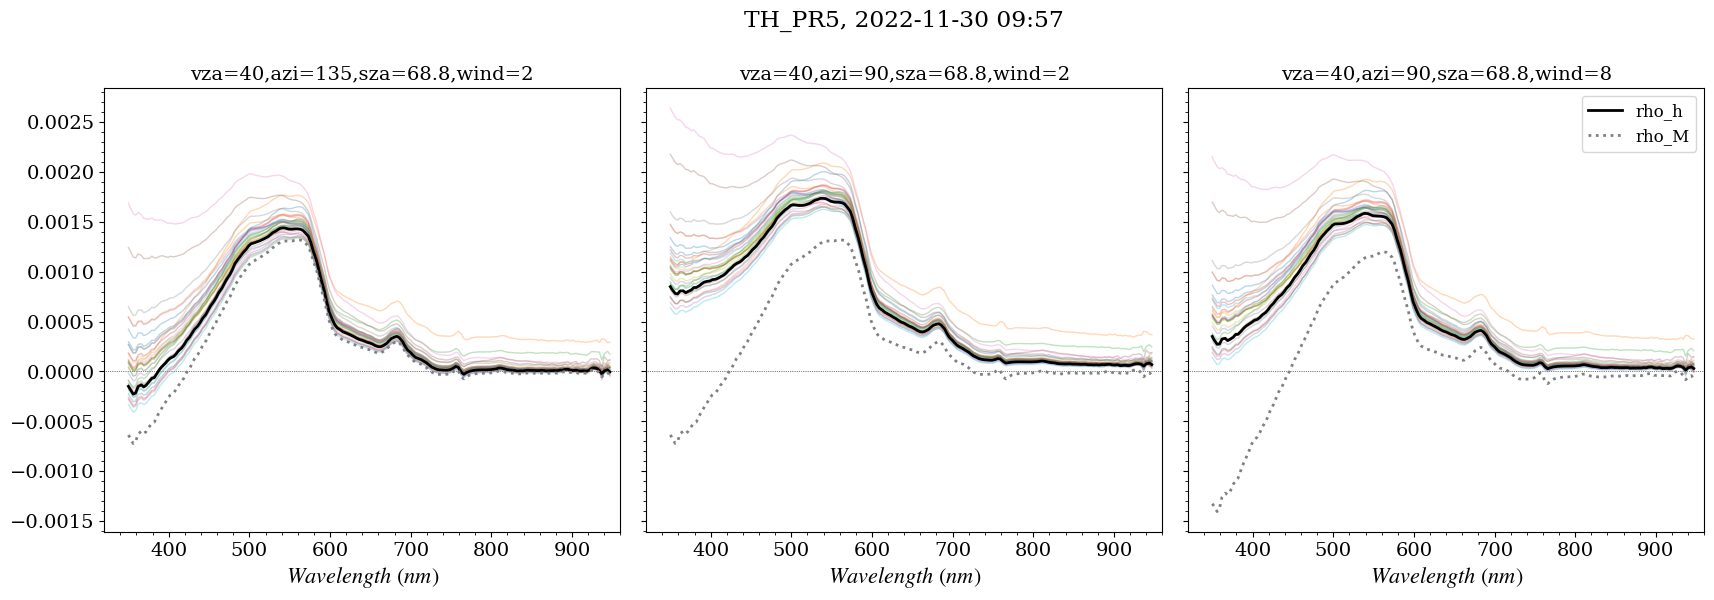

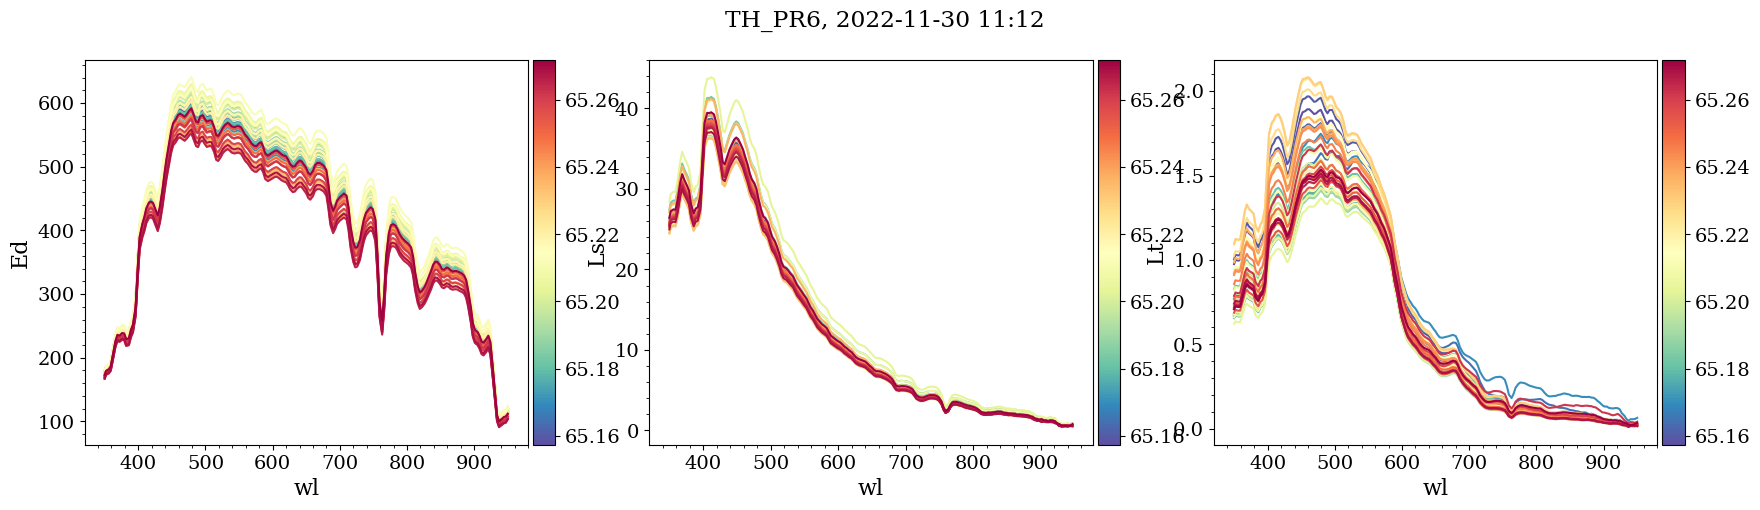

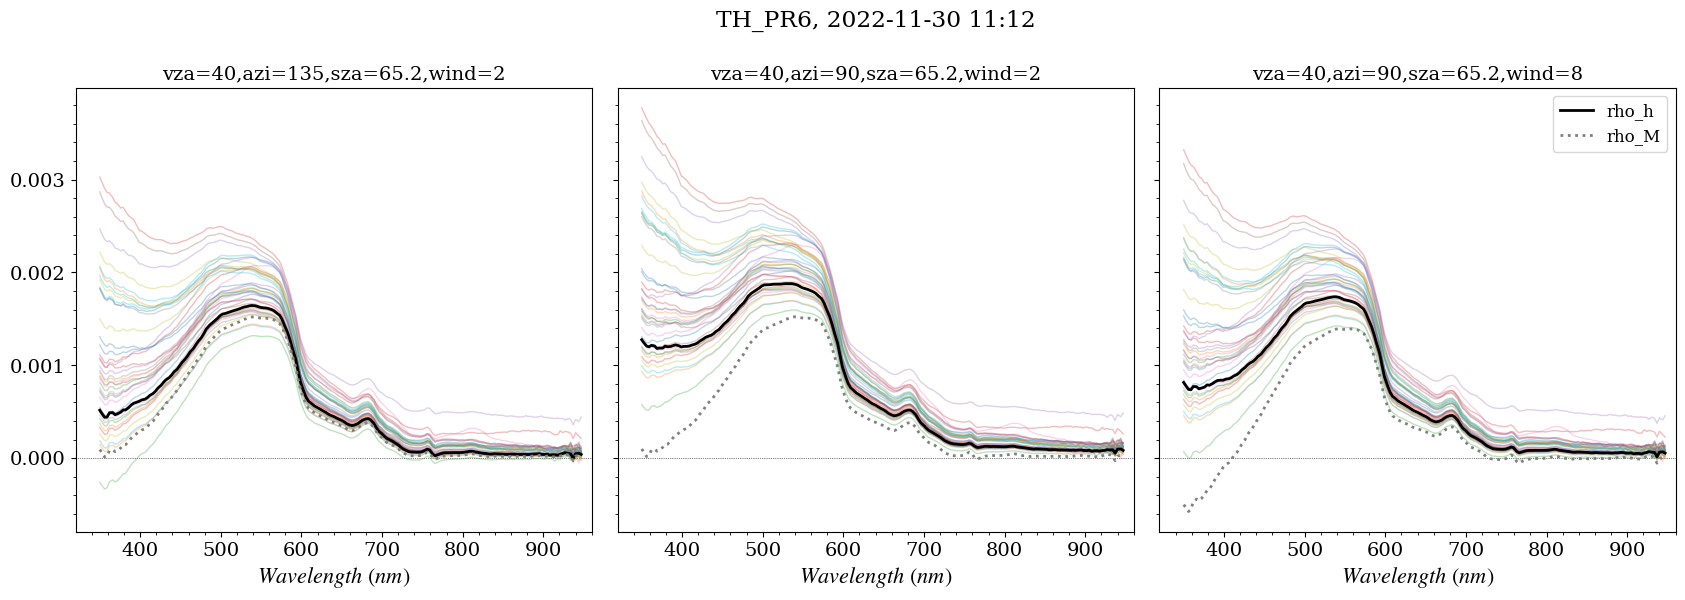

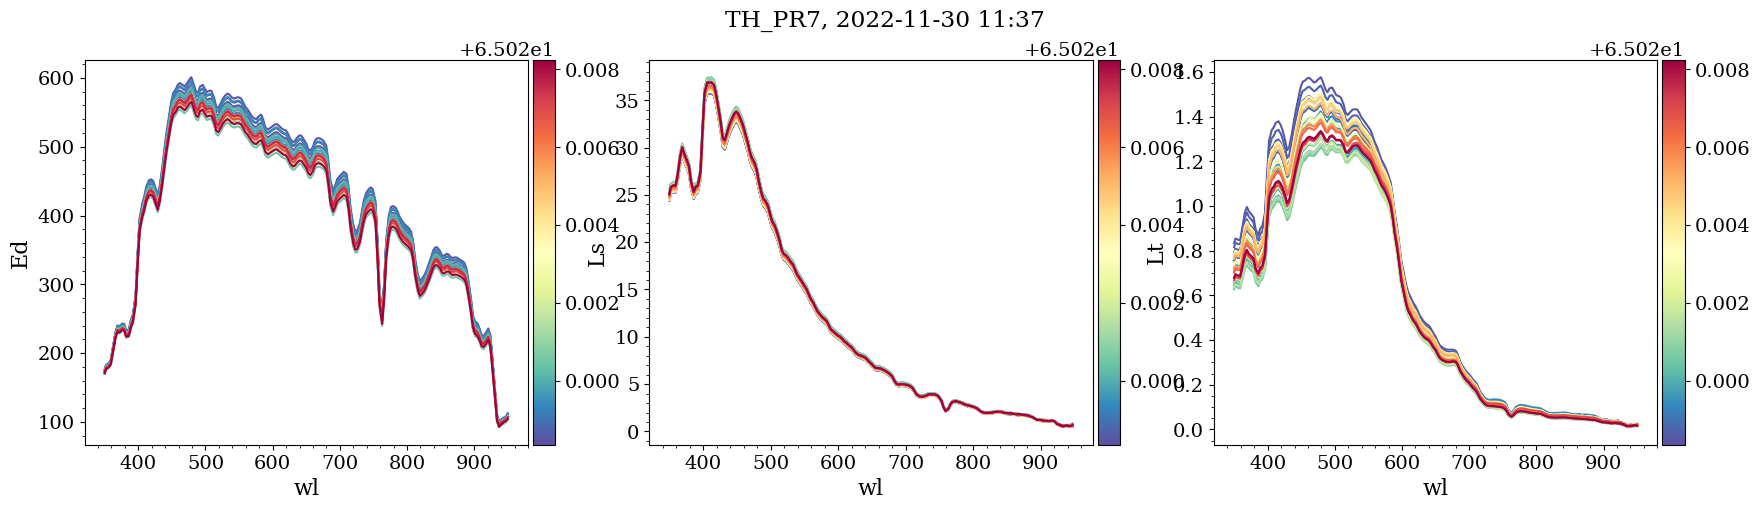

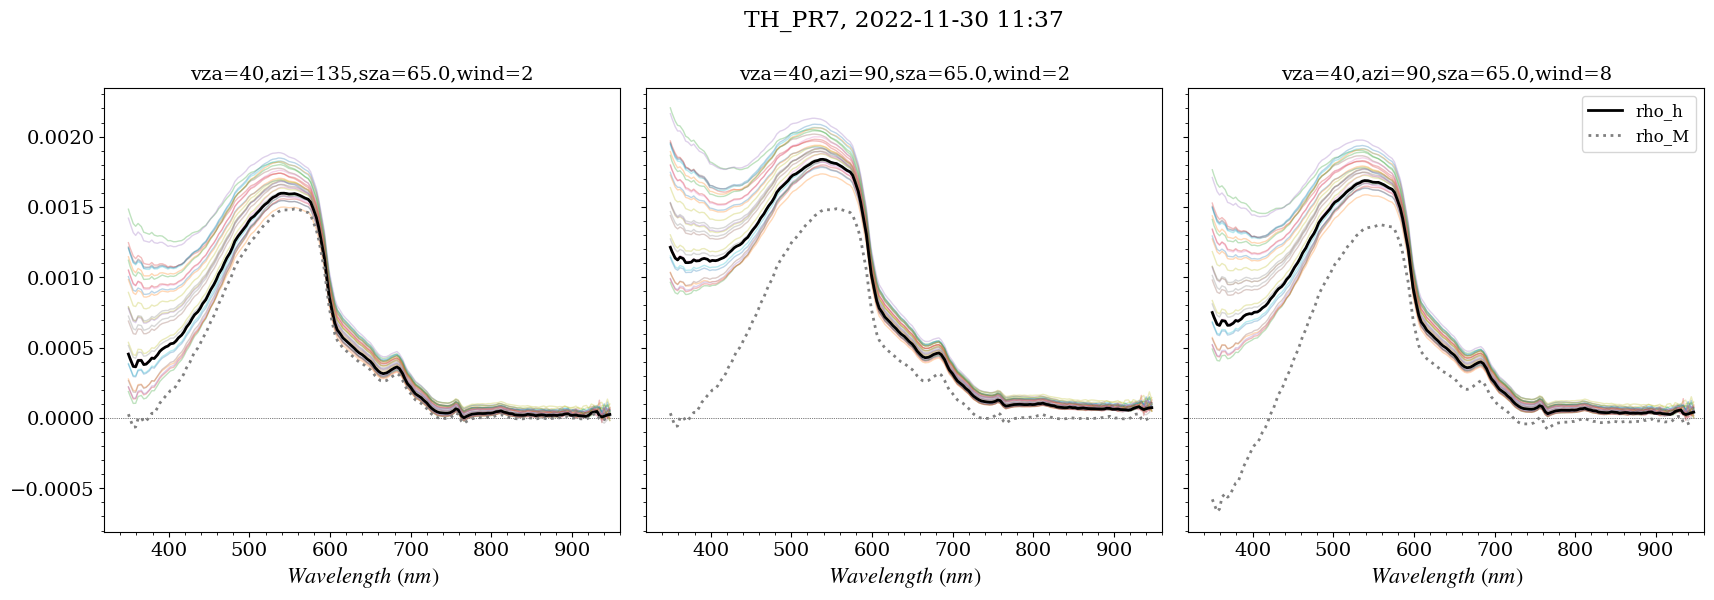

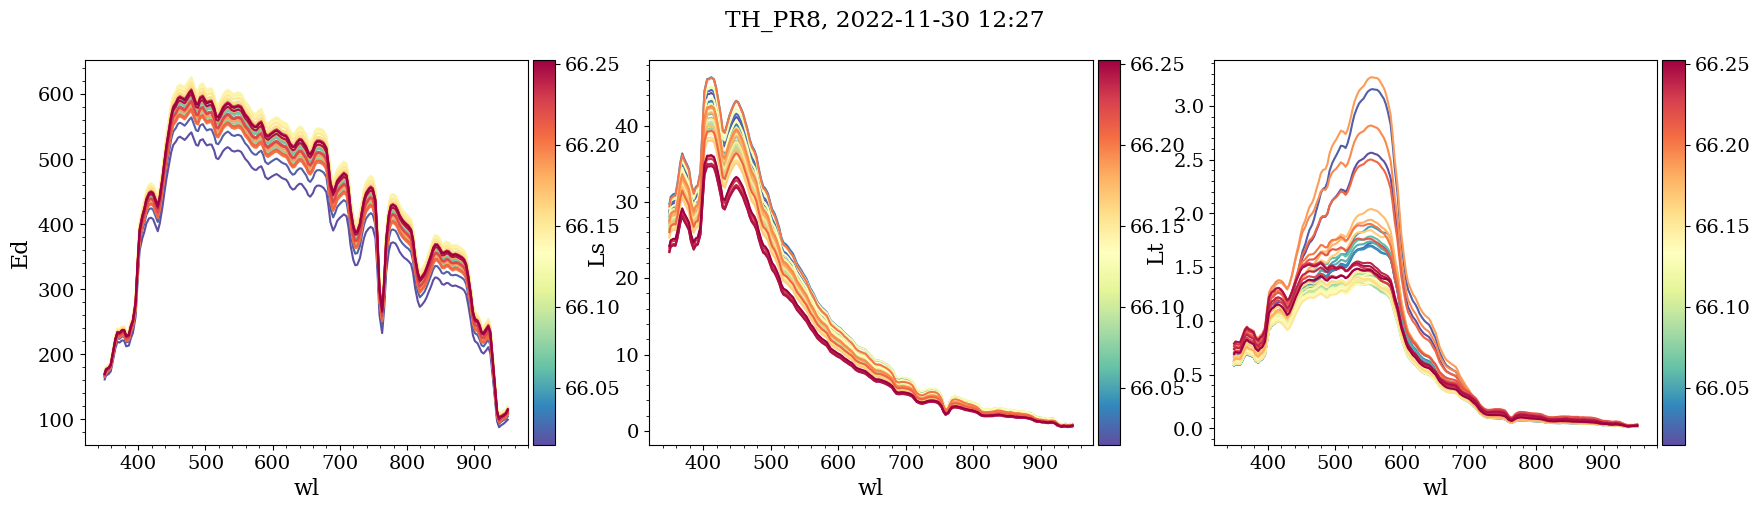

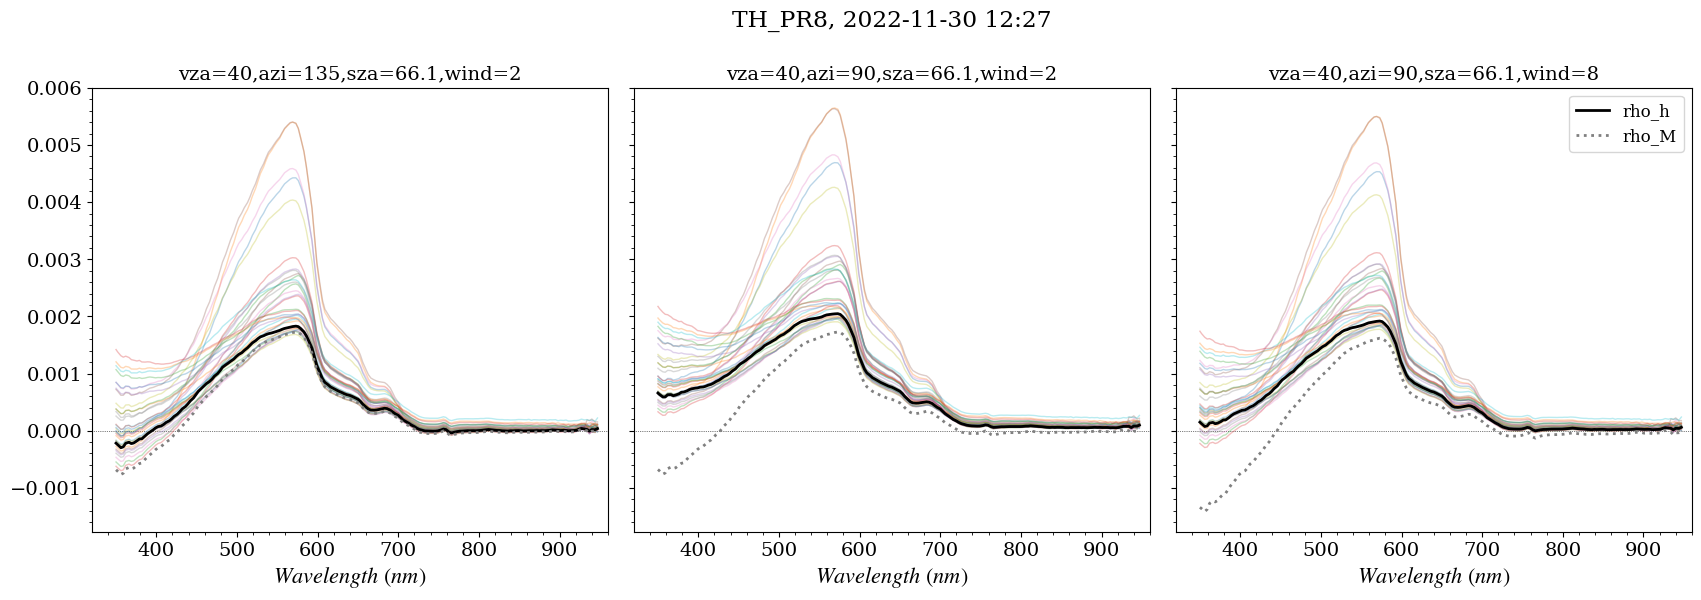

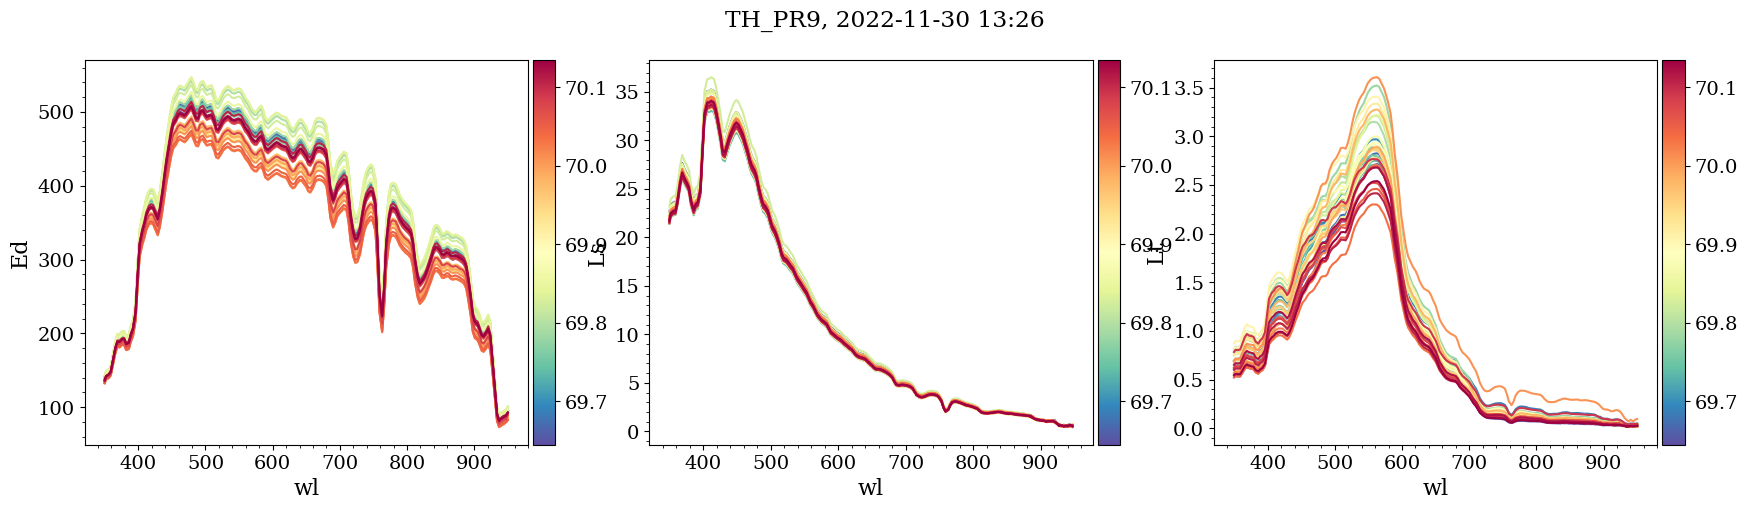

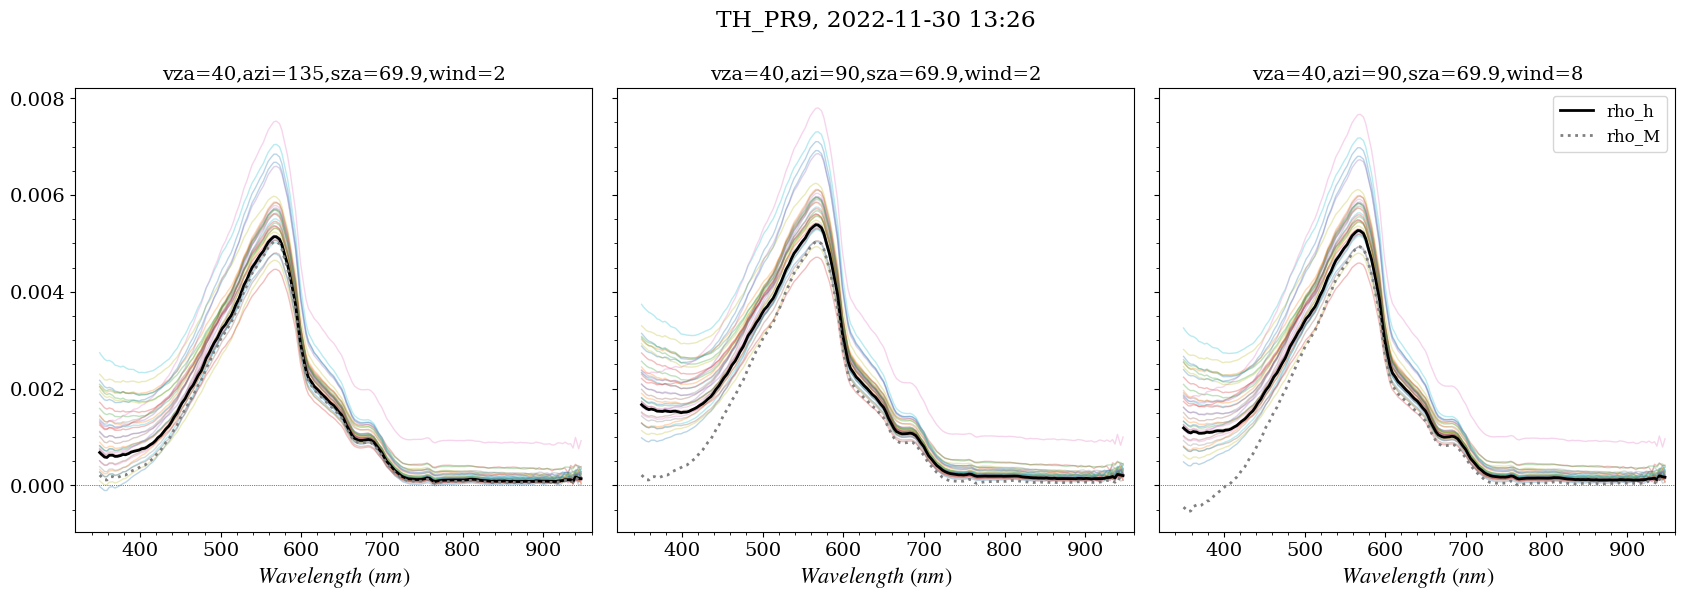

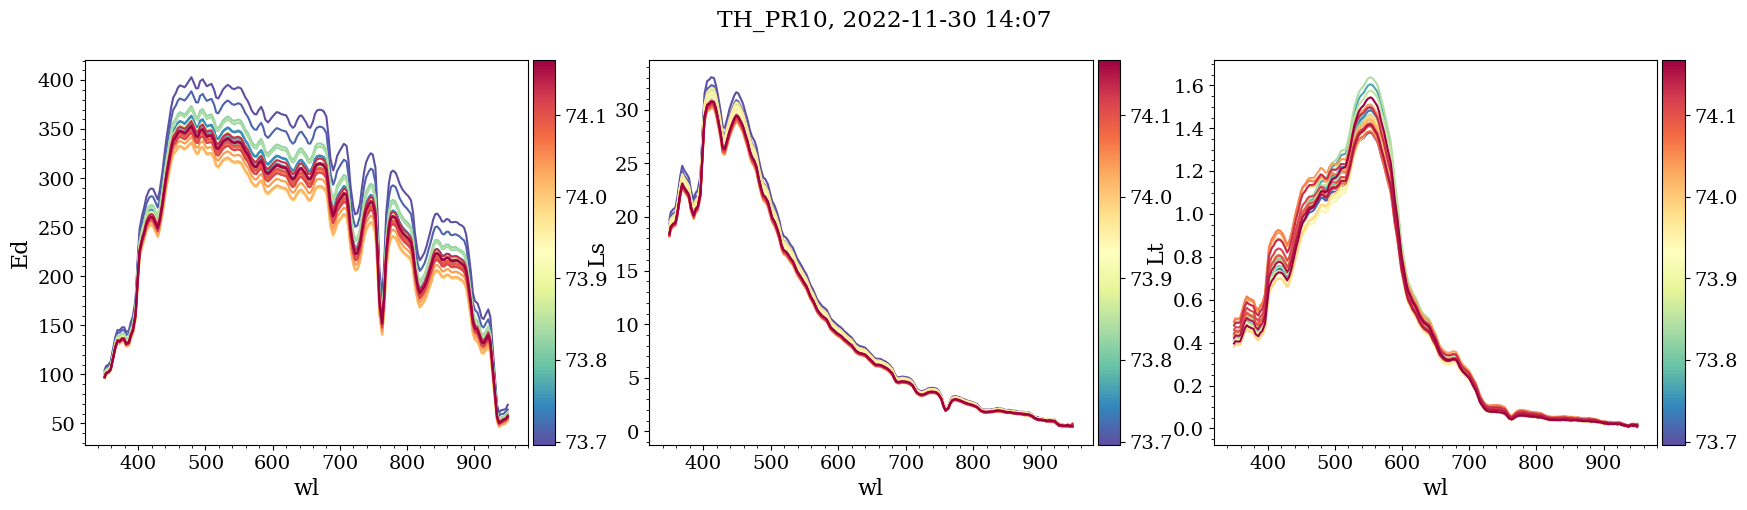

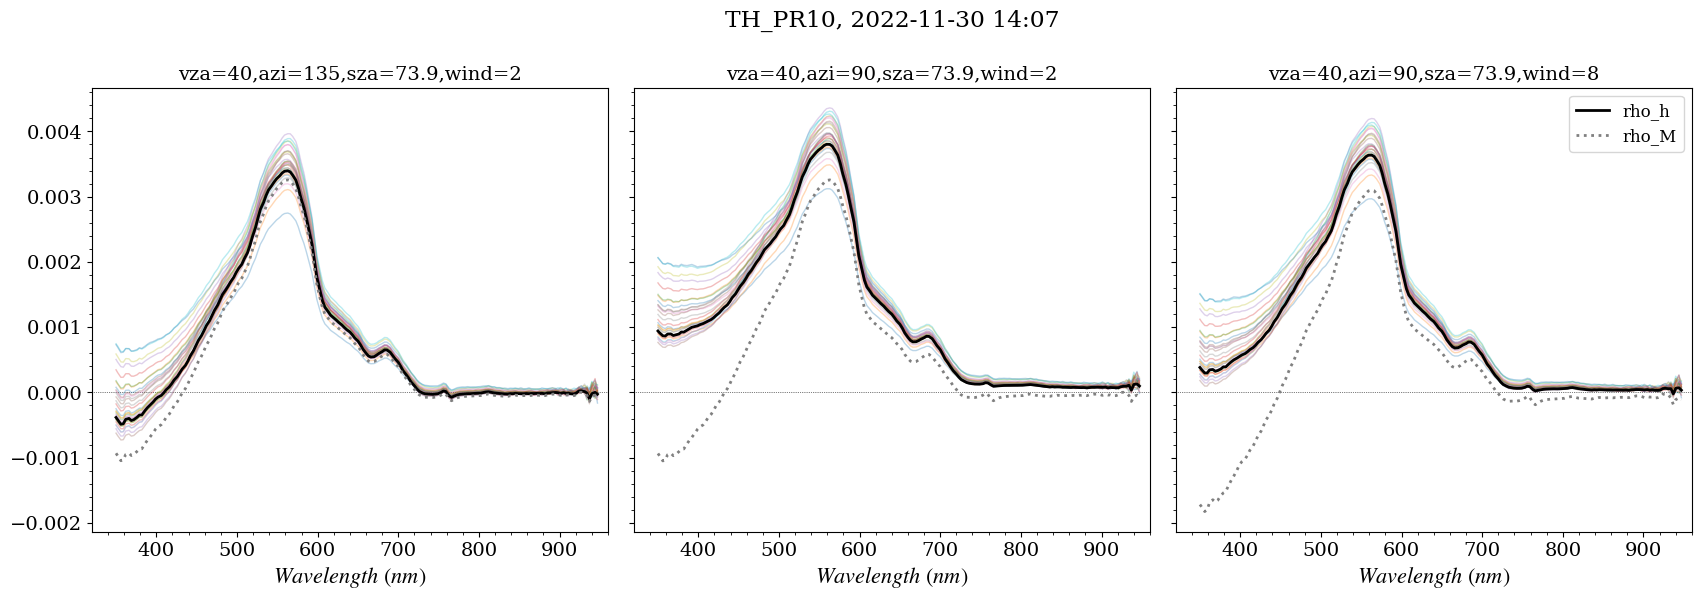

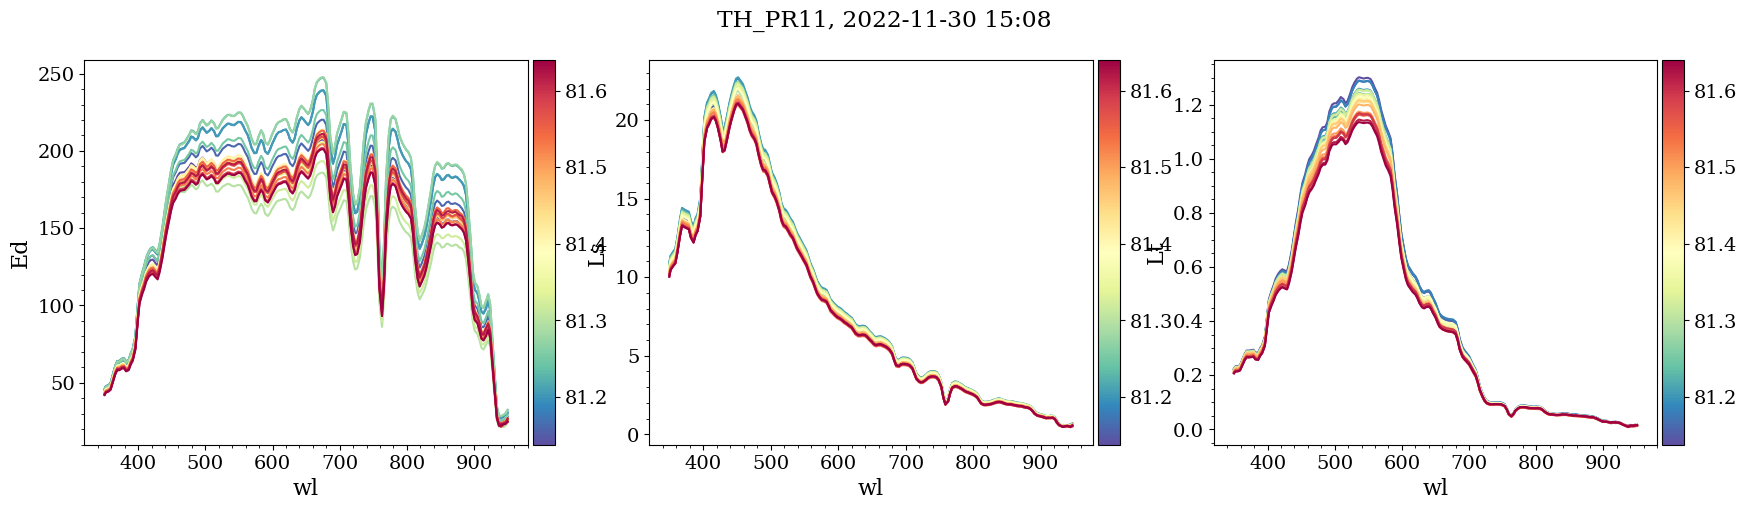

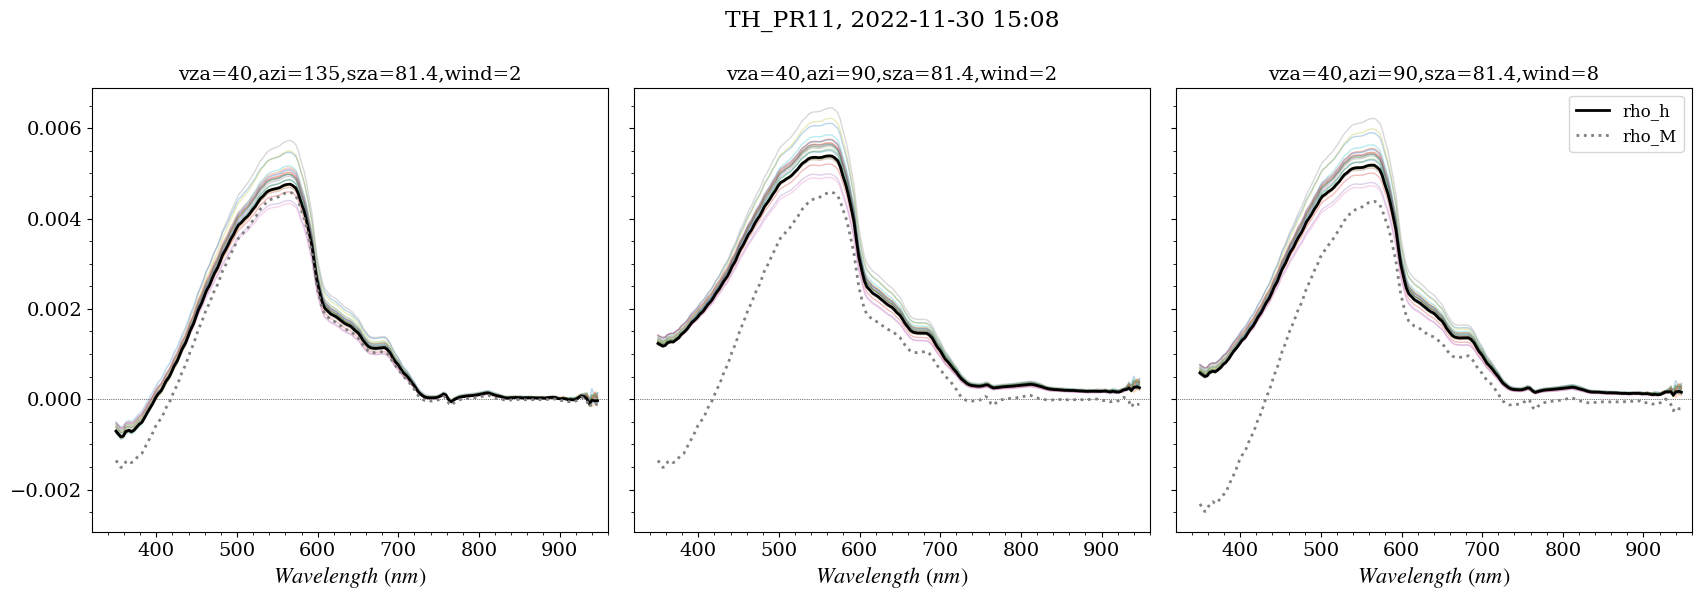

In [31]:
from matplotlib.backends.backend_pdf import PdfPages

lon, lat = 3.6, 43.4
elevation=0

awr_fine = awr_process(wl=common_wl, aerosol = 'fine')
rho = awr_fine.get_rho_values #(60,40,135,wl=common_wl)
rho_mobley = awr_fine.get_rho_mobley
rho_mobley  = awr_fine.rhoM1999.to_xarray().rho
results=[]
cmap = plt.cm.Spectral_r
odir = '/DATA/projet/magellium/malaigue/data/'
with PdfPages(opj(odir,'AWR_TH_nov2022.pdf')) as pdf:
    for id,rep in idpr.iterrows():
        rep=rep.rep
        print(rep)
        # set file paths
        Edfile = opj(datadir,rep,rep+' _ed.xlsx')
        Lsfile = opj(datadir,rep,rep+' _Ls.xlsx')
        Ltfile = opj(datadir,rep,rep+' _Lt.xlsx')
        # open and merge
        data = xr.merge([reshape_data(Edfile,name='Ed',common_wl=common_wl),
                  reshape_data(Lsfile,name='Ls',common_wl=common_wl),
                  reshape_data(Ltfile,name= 'Lt',common_wl=common_wl)])


        sun = suncalc.get_position(data.date,lon, lat)
        sza=90-np.degrees(sun['altitude'])
        rho_factor_ =rho_factor.interp(sza=sza).interp(wl=common_wl)
        data['sza'] = ('date',sza.values)
        date_str = str(data.date.mean().dt.strftime('%Y-%m-%d %H:%M').values)

        norm = mpl.colors.Normalize(vmin=np.min(data.sza),vmax=np.max(data.sza))
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)
        for ii, var in enumerate(['Ed','Ls','Lt']):
            axs[ii].minorticks_on()
            for sza,data_ in data.groupby('sza'):
                data_[var].plot(c=cmap(norm(sza)),ax=axs[ii],add_legend=False)

            divider = make_axes_locatable(axs[ii])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(sm, cax=cax, format=mpl.ticker.ScalarFormatter(),
                                shrink=1.0, fraction=0.1, pad=0)
            axs[ii].set_title('')
        plt.suptitle(rep+', '+date_str)
        pdf.savefig()
        #plt.show()


        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6),sharey=True,sharex=True)
        fig.subplots_adjust(left=0.1, right=0.9, top=0.85,hspace=.1, wspace=0.05)
        sza = data.sza.mean()
        azi=135
        vza=40
        wind=2
        rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')
        #Rrs=(data.Lt-rho(sza,vza,azi,ws=[wind],wl=common_wl)*data.Ls)/data.Ed
        Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
        Rrs=(data.Lt-rho_factor_.isel(wind=0).sel(azi=180-azi)*data.Ls)/data.Ed
        Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[0],alpha=0.3)
        Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.,ax=axs[0])
        Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[0],label='rho_M')
        axs[0].set_title('vza={:.0f},azi={:.0f},sza={:.1f},wind={:.0f}'.format(vza,azi,sza,wind),fontsize=14)

        azi=90
        vza=40
        rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')
        Rrs=(data.Lt-rho_factor_.isel(wind=0).sel(azi=180-azi)*data.Ls)/data.Ed
        Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
        Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[1],alpha=0.3,label=None)
        Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.,ax=axs[1])
        Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[1],label='rho_M')
        axs[1].set_title('vza={:.0f},azi={:.0f},sza={:.1f},wind={:.0f}'.format(vza,azi,sza,wind),fontsize=14)

        # get results into xarray
        Rrs_output = Rrs.quantile(0.25,dim='date')
        Rrs_output['ID']=id
        Rrs_output['idpr']=rep
        Rrs_output['sza']=sza
        Rrs_output['date']=data.date.mean().values
        results.append(Rrs_output)

        wind=8
        rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=np.min([sza,80]),method='quadratic')
        Rrs=(data.Lt-rho_factor_.isel(wind=3).sel(azi=180-azi)*data.Ls)/data.Ed
        Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
        Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[2],alpha=0.3)
        Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.,ax=axs[2],label='rho_h')
        Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[2],label='rho_M')
        axs[2].legend(fontsize=12)
        axs[2].set_title('vza={:.0f},azi={:.0f},sza={:.1f},wind={:.0f}'.format(vza,azi,sza,wind),fontsize=14)
        plt.suptitle(rep+', '+date_str)

        for ii in range(3):
            axs[ii].hlines(0,320,960,ls=':',lw=0.5,color='black',zorder=0)

            axs[ii].minorticks_on()
            axs[ii].set_xlabel('$Wavelength\ (nm)$')
        axs[0].set_xlim(320,960)
        #plt.show()
        #pdf.savefig()



In [24]:
Rrs_L2 = xr.concat(results,dim='ID')
Rrs_L2.to_netcdf('/DATA/projet/magellium/malaigue/data/thau_nov2022/Rrs_TH34_2022.nc')

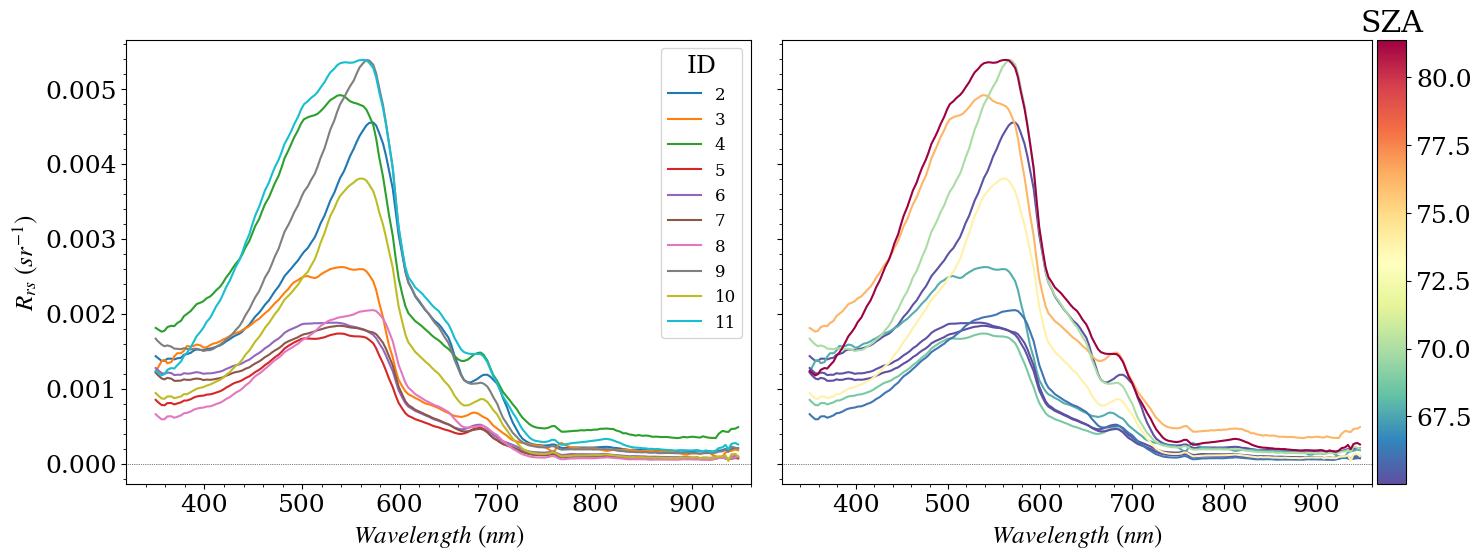

In [25]:
norm = mpl.colors.Normalize(vmin=np.min(Rrs_L2.sza),vmax=np.max(Rrs_L2.sza))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig, axs = plt.subplots(1,2, figsize=(16, 6),sharey=True,sharex=True)
fig.subplots_adjust(left=0.1, right=0.9, top=0.85,hspace=.1, wspace=0.05)
for id,Rrs_ in Rrs_L2.groupby('ID'):
    Rrs_.plot(label=str(id),ax=axs[0],add_legend=False)
    Rrs_.plot(c=cmap(norm(Rrs_.sza)),ax=axs[1],add_legend=False)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, format=mpl.ticker.ScalarFormatter(),
                    shrink=1.0, fraction=0.1, pad=0)
cbar.ax.set_title('SZA')
axs[0].legend(title='ID',fontsize=12)
for ii in range(2):
    axs[ii].minorticks_on()
    axs[ii].set_xlabel('$Wavelength\ (nm)$')
    axs[ii].set_title('')
    axs[ii].hlines(0,320,960,ls=':',lw=0.5,color='black',zorder=0)
axs[0].set_xlim(320,960)
axs[0].set_ylabel('$R_{rs}\ (sr^{-1})$')
plt.show()

In [26]:
Rrs_L2

<xarray.DataArray (ID: 10, wl: 182)>
array([[1.43345623e-03, 1.41113560e-03, 1.37142571e-03, ...,
        2.04737368e-04, 2.04570676e-04,            nan],
       [1.23090581e-03, 1.27137842e-03, 1.36570372e-03, ...,
        1.86443135e-04, 1.77893887e-04,            nan],
       [1.81007004e-03, 1.79293091e-03, 1.76006959e-03, ...,
        4.65670087e-04, 4.86096016e-04,            nan],
       ...,
       [1.66663454e-03, 1.63633852e-03, 1.58830703e-03, ...,
        2.10869350e-04, 2.01264706e-04,            nan],
       [9.41681014e-04, 9.14560781e-04, 8.68809361e-04, ...,
        1.29247047e-04, 9.79565363e-05,            nan],
       [1.23555382e-03, 1.21617163e-03, 1.17742697e-03, ...,
        2.75367205e-04, 2.55004036e-04,            nan]])
Coordinates:
  * wl        (wl) int64 350 352 356 359 362 366 369 ... 934 937 940 944 947 950
    quantile  float64 0.25
  * ID        (ID) int64 2 3 4 5 6 7 8 9 10 11
    idpr      (ID) <U7 'TH_PR2' 'TH_PR3' 'TH_PR4' ... 'TH_PR10' 'TH_PR11'
    sza       (ID) float64 65.2 67.72 76.22 68.76 ... 66.13 69.89 73.93 81.39
    date      (ID) datetime64[ns] 2022-11-29T12:03:11 ... 2022-11-30T15:08:02